## facematch

Aqui, espero conseguir mesmo que de maneira rudimentar encontrar os vetores que represetam os dois rostos. Para isso, pretendo utilizar o 'pacote' https://github.com/DefTruth/torchlm.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import sys
sys.path.append('../')
from facematch import Facematch
%load_ext autotime

time: 352 µs (started: 2024-02-29 16:10:25 -03:00)


In [2]:
#load parquet

df = pd.read_parquet('../base/filtered_data.parquet')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5173 entries, 0 to 23593
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  5173 non-null   object
 1   approved            5173 non-null   bool  
 2   analysis_status     5154 non-null   object
 3   kind                5173 non-null   object
 4   month               5173 non-null   int32 
 5   registration_image  5173 non-null   object
 6   comparision_image   5173 non-null   object
dtypes: bool(1), int32(1), object(5)
memory usage: 267.7+ KB
time: 49.4 ms (started: 2024-01-29 13:35:43 -03:00)


In [ ]:
def verify_faces(imgs_dict):
    registration_image = imgs_dict.get('registration_image')
    comparision_image = imgs_dict.get('comparision_image')
    
    verify = Facematch.verify(registration_image, comparision_image)

    similarity = verify.get('similarity')
    time_ = verify.get('time')
    r_image_confidence = verify.get('confidence').get('r_image')
    c_image_confidence = verify.get('confidence').get('c_image')

    return_dict = {
        'similarity': similarity,
        'time': time_,
        'r_image_confidence': r_image_confidence,
        'c_image_confidence': c_image_confidence
    }
    return return_dict

In [3]:
def verify_faces(row):
    registration_image = cv2.imread('../base/imagens/' + row['registration_image'])
    comparision_image = cv2.imread('../base/imagens/' + row['comparision_image'])

    verify = Facematch.verify(registration_image, comparision_image)

    similarity = verify.get('similarity')
    time_ = verify.get('time')
    r_image_confidence = verify.get('confidence').get('r_image')
    c_image_confidence = verify.get('confidence').get('c_image')

    return similarity, time_, r_image_confidence, c_image_confidence

df[['similarity', 'time', 'r_image_confidence', 'c_image_confidence']] = df.apply(verify_faces, axis=1, result_type='expand')

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


time: 40min 44s (started: 2024-01-29 13:35:43 -03:00)


In [3]:
#save df as parquet

df = pd.read_parquet('../base/filtered_scored_data.parquet')
#df.to_parquet('../base/filtered_scored_data.parquet')

time: 42.2 ms (started: 2024-02-29 16:10:56 -03:00)


In [4]:
df = df[df.similarity != 0]

time: 8.08 ms (started: 2024-02-29 16:11:04 -03:00)


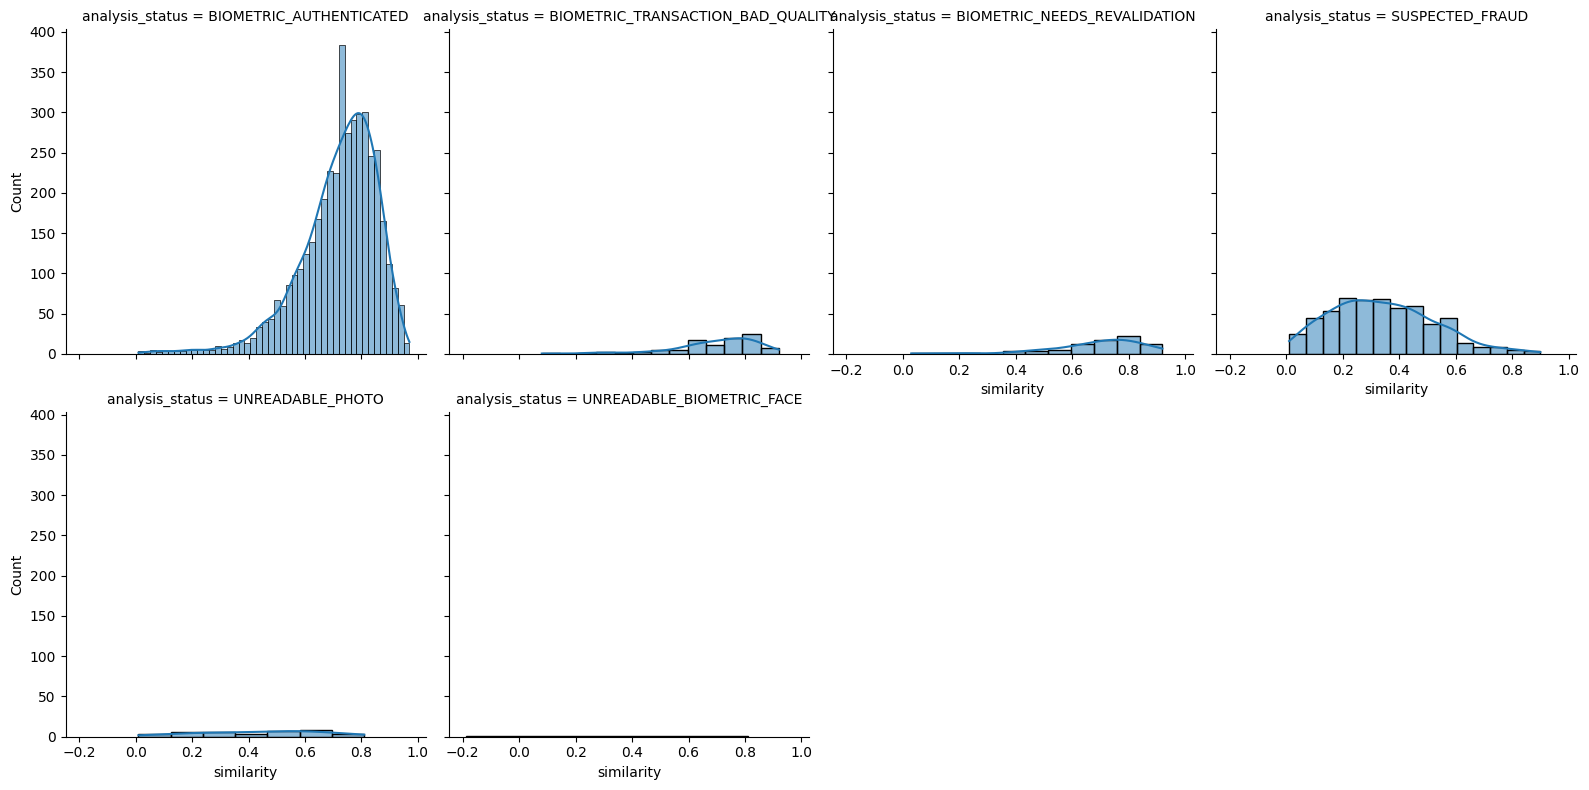

time: 2.06 s (started: 2024-02-29 16:11:06 -03:00)


In [5]:
g = sns.FacetGrid(df, col="analysis_status", col_wrap=4, height=4)
g.map(sns.histplot, "similarity", kde=True)

In [6]:
average_similarity_by_status = df.groupby('analysis_status')['similarity'].mean()
average_similarity_by_status

analysis_status
BIOMETRIC_AUTHENTICATED              0.719215
BIOMETRIC_NEEDS_REVALIDATION         0.691026
BIOMETRIC_TRANSACTION_BAD_QUALITY    0.698866
SUSPECTED_FRAUD                      0.340708
UNREADABLE_BIOMETRIC_FACE            0.310000
UNREADABLE_PHOTO                     0.443684
Name: similarity, dtype: float64

time: 14.4 ms (started: 2024-02-29 16:11:09 -03:00)


In [7]:
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp


time: 125 ms (started: 2024-02-29 16:11:11 -03:00)


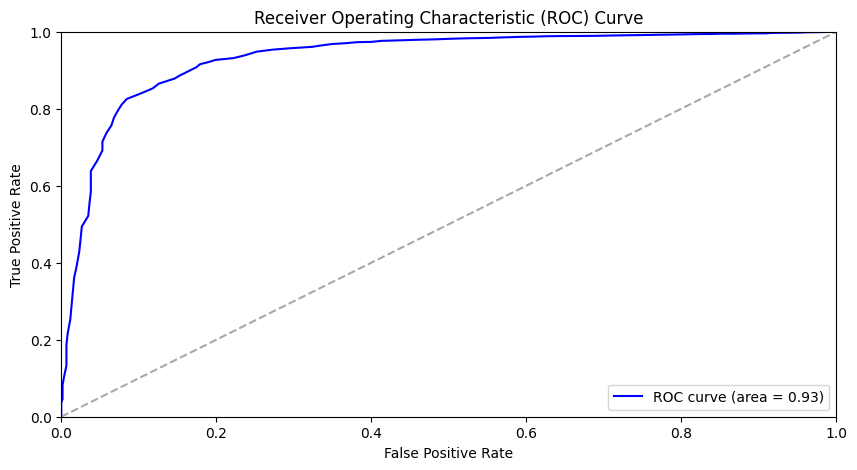

AUC Score: 0.93
KS Statistic: 0.74, KS P-value: 1.305674043493576e-292
time: 290 ms (started: 2024-02-29 16:11:18 -03:00)


In [8]:
df_stats = df.copy()
df_stats = df_stats[df_stats['similarity'] > 0]

# Convert 'approved' to binary
df_stats['approved'] = df_stats['approved'].astype(int)
df_stats['similarity'] = df_stats['similarity']

# Calculate AUC
auc_score = roc_auc_score(df_stats['approved'], df_stats['similarity'])

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(df_stats['approved'], df_stats['similarity'])

# Calculate KS Statistic
ks_statistic, ks_pvalue = ks_2samp(df_stats.loc[df_stats['approved'] == 1, 'similarity'], df_stats.loc[df_stats['approved'] == 0, 'similarity'])

# Plot ROC Curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score: {round(auc_score,2)}")
print(f"KS Statistic: {round(ks_statistic,2)}, KS P-value: {ks_pvalue}")


In [16]:
binning_df

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Non-event over total
0,"(-inf, 0.3)",387,0.077000,304,83,0.214470,3.290843,1.597311,0.140795,0.252073
1,"[0.3, 0.5)",256,0.050935,134,122,0.476562,2.086475,0.406110,0.043186,0.111111
2,"[0.5, 0.5)",264,0.052527,60,204,0.772727,0.768881,0.041043,0.005008,0.049751
3,"[0.5, 0.7)",1274,0.253482,82,1192,0.935636,-0.684012,0.091325,0.011198,0.067993
4,"[0.7, inf)",2845,0.566057,23,2822,0.991916,-2.817051,1.689909,0.160988,0.019071
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,0.000000
Totals,,5026,1.000000,603,4423,0.880024,,3.825697,0.361175,0.500000


time: 30.6 ms (started: 2024-01-29 14:20:51 -03:00)


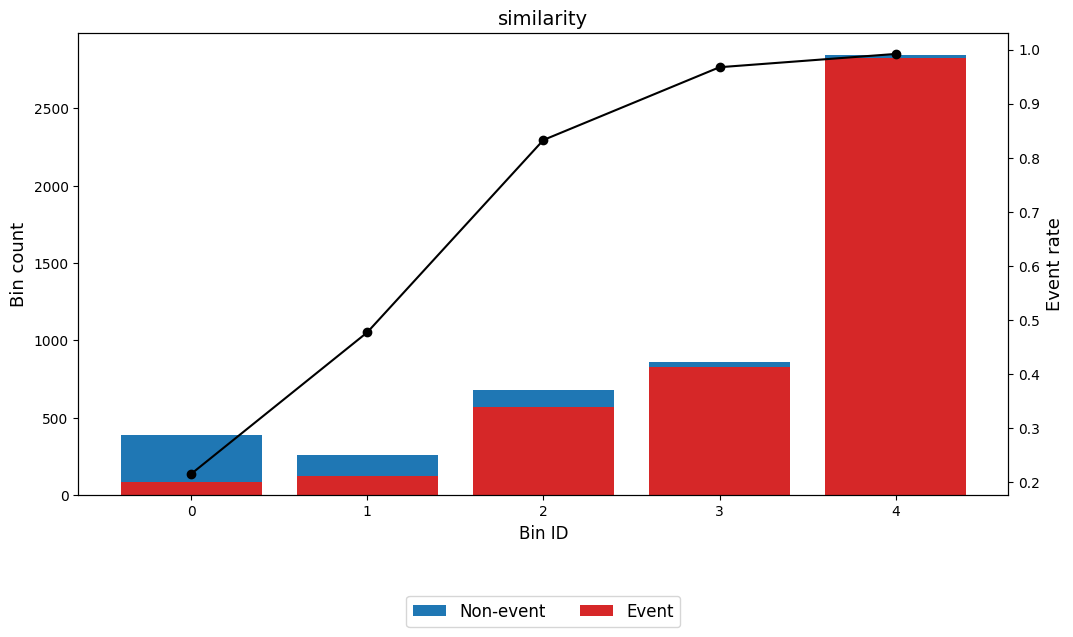

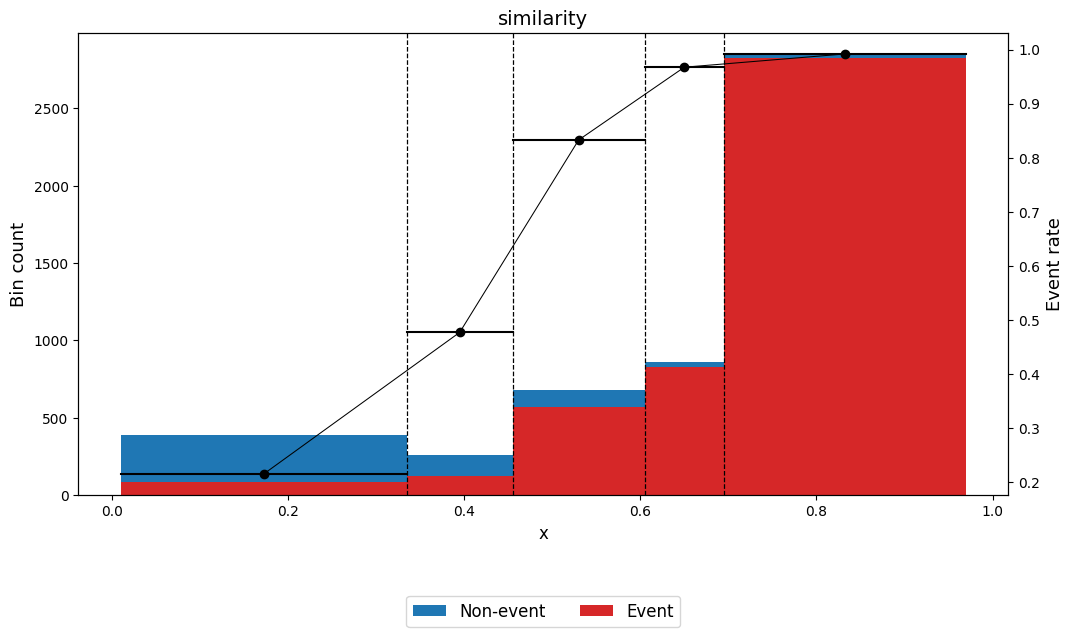

time: 1.28 s (started: 2024-02-29 16:16:04 -03:00)


In [16]:
from optbinning import OptimalBinning
optb = OptimalBinning(name='similarity', dtype="numerical", solver="cp", max_n_bins = 10, min_n_bins = 3, max_pvalue = 1e-5, min_bin_size = 0.001, special_codes=None)
optb.fit(df_stats.similarity.values, df_stats.approved.values)
binning_df = optb.binning_table.build(show_digits = 1)
optb.binning_table.plot(metric="event_rate", add_special=False, add_missing=False, figsize=(12, 6))
optb.binning_table.plot(metric="event_rate", style="actual",add_special=False, add_missing=False, figsize=(12, 6))

binning_df['Non-event over total'] = binning_df['Non-event'] / binning_df['Non-event'].values[:-1].sum()

binning_df = binning_df[['Bin' , 'Count (%)', 'Event rate']].rename(columns={'Event rate': '% Sucesso'}).iloc[:-3].style.background_gradient(cmap='RdYlGn')

#save df as image
#, 'Non-event over total'
import dataframe_image as dfi
dfi.export(binning_df,"mytable.png")


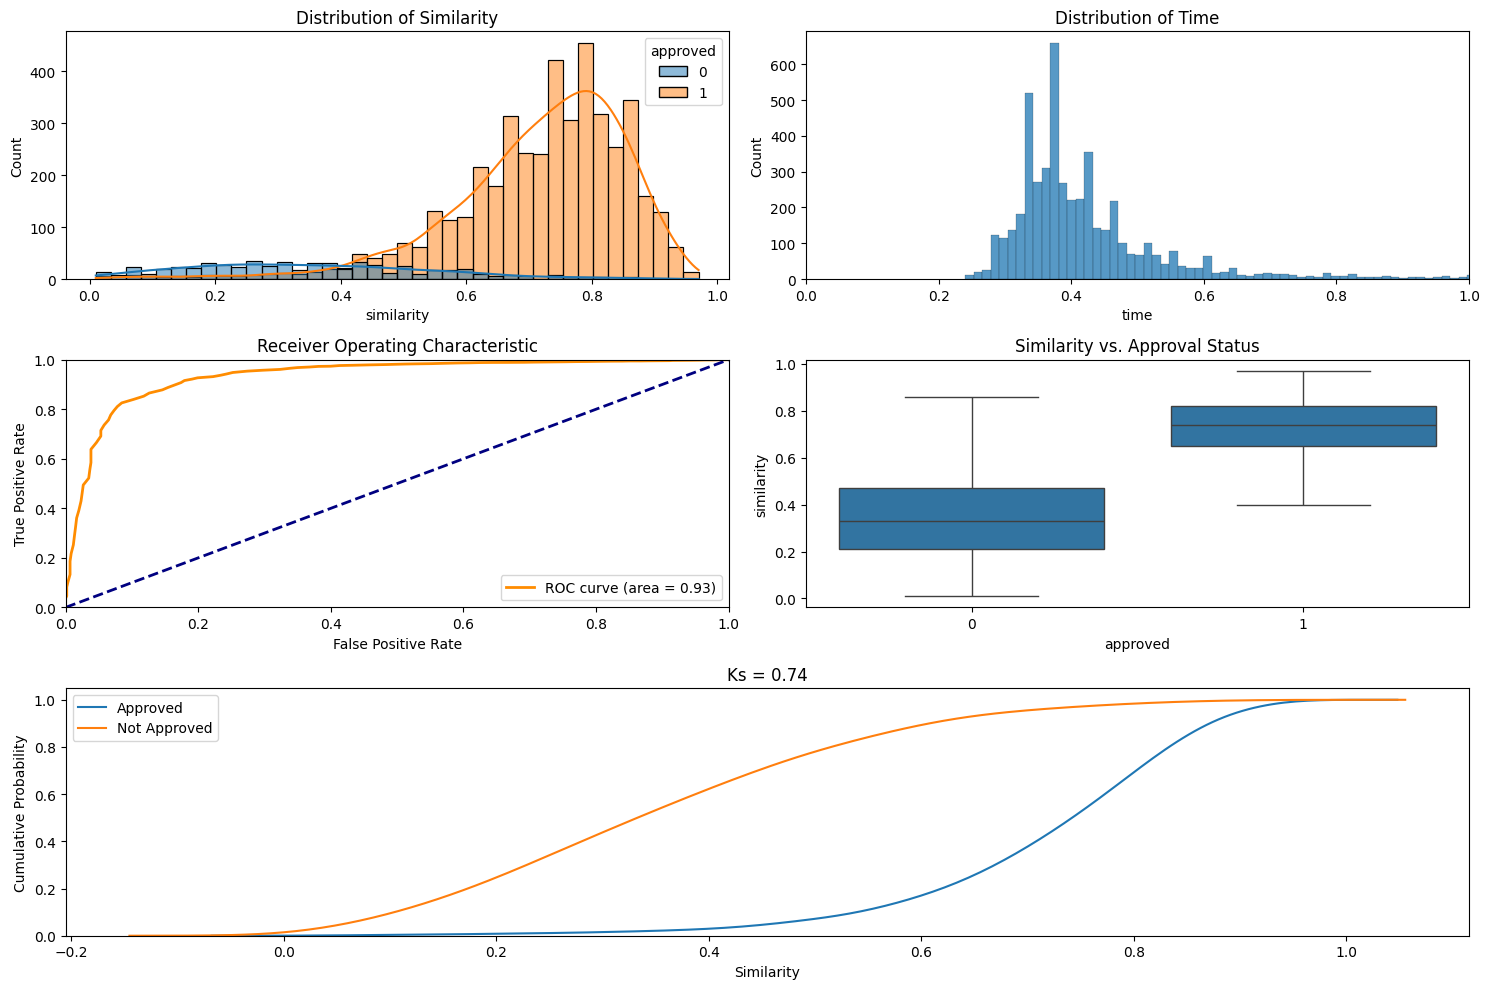

time: 1.32 s (started: 2024-02-29 16:16:55 -03:00)


In [17]:
# Convert 'approved' to binary for analysis
df_stats['approved_binary'] = df_stats['approved'].astype(int)

# Plotting distributions and relationships
plt.figure(figsize=(15, 10))

# Distribution of 'similarity'
plt.subplot(3, 2, 1)
sns.histplot(df_stats,x = 'similarity', kde=True, hue = 'approved')
plt.title('Distribution of Similarity')

# Distribution of 'time'
plt.subplot(3, 2, 2)
sns.histplot(df_stats['time'], kde=False)
plt.xlim(0,1)
plt.title('Distribution of Time')
0.05
# ROC Curve
fpr, tpr, _ = roc_curve(df_stats['approved_binary'], df_stats['similarity'])
roc_auc = auc(fpr, tpr)

plt.subplot(3, 2, 3)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Similarity vs. Approval Status
plt.subplot(3, 2, 4)
sns.boxplot(x='approved', y='similarity', data=df_stats, showfliers=False)
plt.title('Similarity vs. Approval Status')

# KS Plot
plt.subplot(3, 1, 3)
sns.kdeplot(df_stats.loc[df_stats['approved'] == 1, 'similarity'], cumulative=True, label='Approved')
sns.kdeplot(df_stats.loc[df_stats['approved'] == 0, 'similarity'], cumulative=True, label='Not Approved')
plt.xlabel('Similarity')
plt.ylabel('Cumulative Probability')
plt.title(f'Ks = {round(ks_statistic,2)}')
plt.legend()

plt.tight_layout()
plt.show()


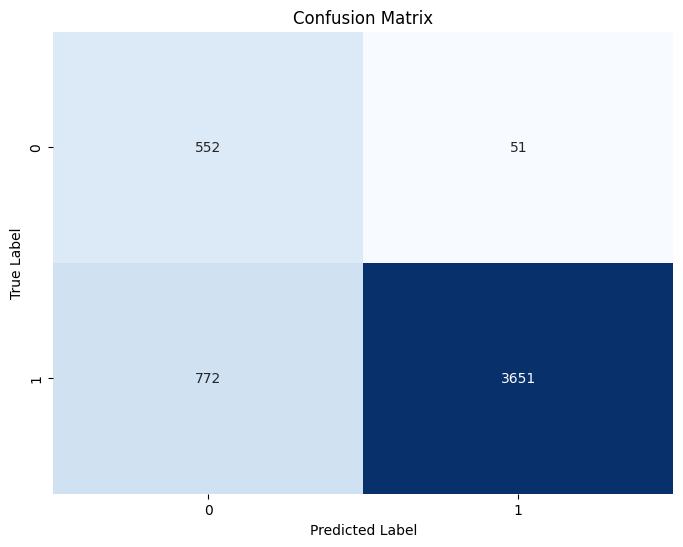

Optimal Threshold: 0.6
Accuracy at Optimal Threshold: 0.84
Precision at Optimal Threshold: 0.95
Recall at Optimal Threshold: 0.97
time: 162 ms (started: 2024-02-29 16:17:05 -03:00)


In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve
import numpy as np

# Calculate optimal threshold using precision-recall curve
precision, recall, thresholds = precision_recall_curve(df_stats['approved_binary'], df_stats['similarity'])
f1_scores = 2 * recall * precision / (recall + precision)
optimal_idx = np.nanargmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold = 0.6
# Apply threshold to 'similarity' to get predicted classifications
df_stats['predicted'] = (df_stats['similarity'] > optimal_threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(df_stats['approved_binary'], df_stats['predicted'])

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Not Approved', 'Approved'], yticklabels=['Not Approved', 'Approved'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print Optimal Threshold and Related Metrics
optimal_accuracy = accuracy_score(df_stats['approved_binary'], df_stats['predicted'])
optimal_precision = precision[optimal_idx]
optimal_recall = recall[optimal_idx]

print(f"Optimal Threshold: {round(optimal_threshold,2)}")
print(f"Accuracy at Optimal Threshold: {round(optimal_accuracy,2)}")
print(f"Precision at Optimal Threshold: {round(optimal_precision,2)}")
print(f"Recall at Optimal Threshold: {round(optimal_recall,2)}")

